In [2]:
import pandas as pd
import numpy as np
from genre_recommender import preprocess_popularity, recommend_top_movies_by_genres, show_recommendations, get_all_genres
import ipywidgets as widgets
from ipywidgets import Layout, Button, Dropdown, VBox, HBox
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import csr_matrix
import concurrent.futures
from tqdm import tqdm  # Импортируем tqdm для прогресса
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import os
import dill
import multiprocessing
from collections import Counter
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from hdbscan import HDBSCAN
from sklearn.utils import resample
import plotly.express as px
from sklearn.cluster import AgglomerativeClustering
import hdbscan
from sklearn.metrics.pairwise import euclidean_distances
import implicit
import scipy.sparse as sp
from sklearn.decomposition import IncrementalPCA
from scipy.sparse import vstack
from implicit import als
import psutil
from scipy import sparse
import gc
from implicit.als import AlternatingLeastSquares
from sklearn.preprocessing import LabelEncoder

In [2]:
# Устанавливаем максимальную ширину столбца
pd.set_option('display.max_colwidth', 1000)

# Устанавливаем максимальную ширину для столбцов (если они обрезаются)
pd.set_option('display.width', None)


In [3]:
genome_scores = pd.read_csv('content/films/genome-scores.csv')

In [4]:
genome_tags = pd.read_csv('content/films/genome-tags.csv')

In [5]:
links = pd.read_csv('content/films/links.csv')

In [3]:
movies = pd.read_csv('content/films/movies.csv')

In [7]:
ratings = pd.read_csv('content/films/ratings.csv')

In [10]:
tags = pd.read_csv('content/films/tags.csv')

In [11]:
genome_scores

,movieId,tagId,relevance
0,1,1,0.03200
1,1,2,0.02225
2,1,3,0.07000
3,1,4,0.05900
4,1,5,0.12300
...,...,...,...
18472123,288167,1124,0.09875
18472124,288167,1125,0.02950
18472125,288167,1126,0.02275
18472126,288167,1127,0.11225


In [10]:
genome_tags

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


In [11]:
links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
86532,288967,14418234,845861.0
86533,288971,11162178,878958.0
86534,288975,70199,150392.0
86535,288977,23050520,1102551.0


In [11]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
86532,288967,State of Siege: Temple Attack (2021),Action|Drama
86533,288971,Ouija Japan (2021),Action|Horror
86534,288975,The Men Who Made the Movies: Howard Hawks (1973),Documentary
86535,288977,Skinford: Death Sentence (2023),Crime|Thriller


In [12]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119
...,...,...,...,...
33832157,330975,8340,2.0,1091583256
33832158,330975,8493,2.5,1091585709
33832159,330975,8622,4.0,1091581777
33832160,330975,8665,3.0,1091581765


In [13]:
ratings.describe()

,userId,movieId,rating,timestamp
count,3.383216e+07,3.383216e+07,3.383216e+07,3.383216e+07
mean,1.654380e+05,2.831348e+04,3.542540e+00,1.269362e+09
std,9.534122e+04,4.992865e+04,1.063959e+00,2.541023e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,8.295300e+04,1.219000e+03,3.000000e+00,1.046718e+09
50%,1.661290e+05,3.263000e+03,4.000000e+00,1.264740e+09
75%,2.474500e+05,4.049100e+04,4.000000e+00,1.496919e+09
max,3.309750e+05,2.889830e+05,5.000000e+00,1.689843e+09


In [14]:
tags

,userId,movieId,tag,timestamp
0,10,260,good vs evil,1430666558
1,10,260,Harrison Ford,1430666505
2,10,260,sci-fi,1430666538
3,14,1221,Al Pacino,1311600756
4,14,1221,mafia,1311600746
...,...,...,...,...
2328310,330923,176599,politically correct,1507547491
2328311,330933,3317,coming of age,1351279384
2328312,330933,3317,sexuality,1351279389
2328313,330947,5782,Not Luc Besson,1154110902


In [9]:
# Добавляем тэг разхное и добавляем его ко всем фильмам у которых тэгов нет
# Найдём максимальный tagId
max_tag_id = genome_tags['tagId'].max()

# Добавим "miscellaneous" в genome_tags
misc_tag = pd.DataFrame([{'tagId': max_tag_id + 1, 'tag': 'miscellaneous'}])
genome_tags = pd.concat([genome_tags, misc_tag], ignore_index=True)

# Добавим фиктивную релевантность 0.5 для фильмов без тегов
# Сначала найдём такие movieId
tagged_movies = genome_scores['movieId'].unique()
all_movies = movies['movieId'].unique()
untagged_movies = np.setdiff1d(all_movies, tagged_movies)

# Создадим записи для этих фильмов
misc_rows = pd.DataFrame({
    'movieId': untagged_movies,
    'tagId': max_tag_id + 1,
    'relevance': 0.5
})

# Добавим их в genome_scores
genome_scores = pd.concat([genome_scores, misc_rows], ignore_index=True)


In [10]:
# Группируем по userId и считаем количество оценок
user_rating_counts = ratings.groupby('userId').size().reset_index(name='rating_count')

# Фильтруем пользователей, у которых хотя бы 1 оценка (в принципе, можно не фильтровать, т.к. size() уже исключает 0)
user_rating_counts = user_rating_counts[user_rating_counts['rating_count'] > 0]

# Сортируем по возрастанию
anti_top_users = user_rating_counts.sort_values(by='rating_count', ascending=True)

# Выведем, например, 10 пользователей, которые ставили меньше всего оценок
print(anti_top_users.head(10))

        userId  rating_count
99237    99238             1
313546  313547             1
80141    80142             1
109843  109844             1
148384  148385             1
211814  211815             1
20475    20476             1
253764  253765             1
196577  196578             1
211806  211807             1


In [11]:
# Проверим, сколько фильмов имеет каждый из жанров, на которые мы сокращаем
def check_genre_availability(genres_list, movies_df):
    # Ищем фильмы, которые содержат хотя бы один жанр из списка
    available_movies = movies_df[movies_df['genres'].apply(lambda x: any(genre in x for genre in genres_list))]
    print(f"[INFO] Найдено {len(available_movies)} фильмов с жанрами {genres_list}")
    print(available_movies[['movieId', 'title', 'genres']])

# Проверим наличие фильмов для каждого из жанров, которые мы используем
check_genre_availability(['Action'], movies)
check_genre_availability(['Adventure'], movies)
check_genre_availability(['Sci-Fi'], movies)

[INFO] Найдено 9563 фильмов с жанрами ['Action']
       movieId                                 title  \
5            6                           Heat (1995)   
8            9                   Sudden Death (1995)   
9           10                      GoldenEye (1995)   
14          15               Cutthroat Island (1995)   
19          20                    Money Train (1995)   
...        ...                                   ...   
86505   288895                    Night Train (2023)   
86506   288897                   Warhorse One (2023)   
86517   288931                V for Vengeance (2022)   
86532   288967  State of Siege: Temple Attack (2021)   
86533   288971                    Ouija Japan (2021)   

                                   genres  
5                   Action|Crime|Thriller  
8                                  Action  
9               Action|Adventure|Thriller  
14               Action|Adventure|Romance  
19     Action|Comedy|Crime|Drama|Thriller  
...           

## Что нужно сдеать

1. Сделать таблицу populatiry  на основе ratings (т.е сделать датасет с столбцами: movieId, ave_rating (находим как среднее по каждому фильму по рейтингу из imdb по imdbId)
2. Content-base:
- написать код выдачи топ -10 по populatiry (в соответствии с жанром)  - просто выдача по populatiry + жанр(ы)  (1)
- написать код выдачи рекомендации по фильму. На 1 фильм - 10 рекомендаций.(без учета рейтинга) -рекомендашка (2)

3. User-base:
  - написать код выдачи рекомендации по фильму. На 1 фильм - 10 рекомендаций.(без учета рейтинга) и с изменением весов по тэгу-рекомендашка (3)
  - написать код выдачи рекомендации по фильму. На 1 фильм - 10 рекомендаций.(с учетом рейтинга) -рекомендашка (4)

## Работа с юзерами

1. Юзер новый и хочет рекомендаций- Юзер выбирает жанр и мы выдаем топ -5 по populatiry (в соответствии с жанром)
2. Юзер посмотрел несоклько фильмов - подбираем похожий фильм (жанр, и тэги с учетом их весов (relevance))
3. Юзер посмотрел несколько фильмов и поставил рейтинг менее 5 раз но больше 0. Фиксируем тэг фильмов на которые был поставлен рейтинг. И в зависимости от оценки уменьшаемили увеличиваем веса жанров/тэгов пропорционально оценке.
4. Юзер посмотрел несколько фильмов и поставил рейтинг 5+раз  - подбираем рекомендации ( в соответвии с его рейтингами)

In [15]:
popularity_df = preprocess_popularity(ratings)

# Непосредственно рекомендации
recommend_top_movies_by_genres("Action", "Adventure", movies_df=movies, popularity_df=popularity_df)

,title,genres,ave_rating,rating_count,weighted_rating
44066,Band of Brothers (2001),Action|Drama|War,4.423986,2835,4.419025
1930,Seven Samurai (Shichinin no samurai) (1954),Action|Adventure|Drama,4.250818,17120,4.250095
41020,Over the Garden Wall (2013),Adventure|Animation|Drama,4.256993,1430,4.248352
2867,Fight Club (1999),Action|Crime|Drama|Thriller,4.236019,86207,4.235877
82617,Spider-Man: Across the Spider-Verse (2023),Action|Adventure|Animation|Sci-Fi,4.252841,528,4.229790
5509,Spirited Away (Sen to Chihiro no kamikakushi) ...,Adventure|Animation|Fantasy,4.226035,35375,4.225692
55378,Spider-Man: Into the Spider-Verse (2018),Action|Adventure|Animation|Sci-Fi,4.192053,10885,4.190971
12221,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,4.187539,65349,4.187359
887,North by Northwest (1959),Action|Adventure|Mystery|Romance|Thriller,4.187337,21883,4.186801
5905,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,4.183597,27209,4.183167


In [9]:

# Интерактивный режим 
show_recommendations(movies_df=movies, ratings_df=ratings)

# Ручной метод (ручная сборка векторов)

## 1. Пробуем постой поиск по косинусовому сходству

In [11]:
tag_set = sorted(genome_scores['tagId'].unique())
tag_index = {tag: i for i, tag in enumerate(tag_set)}


def create_tag_vector(movieId, genome_scores, tag_index, vector_len):
    """
    Создает разреженный вектор тегов фиксированной длины с релевантностями.
    """
    movie_tags = genome_scores[genome_scores['movieId'] == movieId]

    indices = []
    data = []

    for _, row in movie_tags.iterrows():
        tag_id = row['tagId']
        relevance = row['relevance']
        if tag_id in tag_index:
            indices.append(tag_index[tag_id])
            data.append(relevance)

    # Проверка на корректность индексов
    if len(indices) == 0:
        print(f"Warning: No valid tags found for movieId {movieId}")
    
    return csr_matrix((data, ([0]*len(indices), indices)), shape=(1, vector_len))

def create_genre_vector(batch, all_genres):
    """
    Преобразует жанры фильмов в one-hot вектора.
    """
    genre_matrix = np.zeros((len(batch), len(all_genres)))
    
    for i, genre_string in enumerate(batch['genres']):
        genres = genre_string.split('|')  # <--- добавили сплит по '|'
        for genre in genres:
            genre = genre.strip()
            if genre in all_genres:
                genre_matrix[i][all_genres.index(genre)] = 1
            else:
                print(f"Warning: Genre {genre} not found in all_genres.")
    
    return pd.DataFrame(genre_matrix, index=batch['movieId'], columns=all_genres)


def create_movie_vectors(movies_df, genome_scores, all_genres):
    """
    Создает разреженную матрицу для каждого фильма на основе жанров и тегов.
    """
    genre_df = create_genre_vector(movies_df, all_genres)
    tag_set = genome_scores['tagId'].unique()
    
    tag_vectors = {}
    for movieId in movies_df['movieId']:
        tag_vectors[movieId] = create_tag_vector(movieId, genome_scores, tag_set)
    
    movie_vectors = {}
    for movieId in movies_df['movieId']:
        genre_vector = genre_df.loc[movieId].values
        tag_vector = tag_vectors[movieId].toarray().flatten()  # Преобразуем разреженный вектор в плотный
        movie_vectors[movieId] = np.concatenate([genre_vector, tag_vector])
    
    return movie_vectors

def recommend_similar_movies(movie_id, movies_df, X_reduced_final, top_n=10):
    """
    Рекомендации по одному фильму на основе косинусного сходства с использованием пониженных векторов.
    """
    print(f"Общее количество векторов фильмов: {len(X_reduced_final)}")

    # Шаг 1: Получаем вектор для целевого фильма (по индексам в X_reduced_final)
    movie_vector = X_reduced_final[movie_id]
    
    # Получаем название фильма
    movie_title = movies_df.loc[movies_df['movieId'] == movie_id, 'title'].values[0]
    
    print(f"\nРекомендации для фильма: '{movie_title}'\n")

    # Шаг 2: Вычисляем сходство по всем фильмам (используем косинусное сходство)
    similarities = cosine_similarity([movie_vector], X_reduced_final)[0]

    # Шаг 3: Сортируем фильмы по похожести
    similar_movies_indices = similarities.argsort()[-top_n-1:-1][::-1]
    
    # Шаг 4: Получаем топ-N похожих фильмов
    similar_movies = movies_df.iloc[similar_movies_indices].copy()  # Копируем, чтобы избежать предупреждения
    similar_movies.loc[:, 'similarity'] = similarities[similar_movies_indices]  # Используем .loc для модификации

    # Выводим топ-N похожих фильмов
    return similar_movies[['title', 'genres', 'similarity']]



def process_batch(batch, all_genres, genome_scores, tag_index, tag_vector_len):
    """
    Обрабатывает одну партию фильмов: генерирует векторы жанров и тегов для фильмов.
    """
    genre_df = create_genre_vector(batch, all_genres)
    tag_vectors = {}

    for movieId in batch['movieId']:
        tag_vectors[movieId] = create_tag_vector(movieId, genome_scores, tag_index, tag_vector_len)

    movie_vectors = {}
    for movieId in batch['movieId']:
        genre_vector = genre_df.loc[movieId].values
        tag_vector = tag_vectors[movieId].toarray().flatten()
        movie_vectors[movieId] = np.concatenate([genre_vector, tag_vector])

    return movie_vectors
    
def process_movie_vectors_in_parallel(movies_df, genome_scores, all_genres, batch_size=1000, usage_ratio=0.6):
    """
    Обрабатывает данные в партиях параллельно, с отображением прогресса.
    usage_ratio — доля доступных ядер, которую можно задействовать (например, 0.6 = 60%)
    """
    total_movies = len(movies_df)
    movie_vectors = {}

    # Получаем фиксированный набор тегов и индекс
    tag_set = sorted(genome_scores['tagId'].unique())
    tag_index = {tag: i for i, tag in enumerate(tag_set)}
    tag_vector_len = len(tag_index)

    # Определяем количество используемых процессов
    cpu_count = multiprocessing.cpu_count()
    used_workers = max(1, int(cpu_count * usage_ratio))
    print(f"[INFO] Доступно ядер: {cpu_count}, будет использоваться: {used_workers}")

    with ProcessPoolExecutor(max_workers=used_workers) as executor:
        futures = []
        with tqdm(total=total_movies, desc="Processing Movies") as pbar:
            for start_idx in range(0, total_movies, batch_size):
                end_idx = min(start_idx + batch_size, total_movies)
                batch = movies_df.iloc[start_idx:end_idx]
                futures.append(
                    executor.submit(
                        process_batch,
                        batch,
                        all_genres,
                        genome_scores,
                        tag_index,
                        tag_vector_len
                    )
                )

            for future in concurrent.futures.as_completed(futures):
                batch_movie_vectors = future.result()
                movie_vectors.update(batch_movie_vectors)
                pbar.update(batch_size)

    return movie_vectors

In [4]:
all_genres = get_all_genres(movies)


In [5]:
all_genres

['(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [37]:
# movie_vectors_all = process_movie_vectors_in_parallel(movies, genome_scores, all_genres)

[INFO] Доступно ядер: 16, будет использоваться: 9


Processing Movies: 87000it [23:33, 61.55it/s]                                                                                                                                                                                                                                                                       


In [38]:
# # Сохраняем данные в файл
# # Создаем директорию, если она не существует
# os.makedirs('content/films', exist_ok=True)

# with open('content/films/movie_vectors_all.dill', 'wb') as f:
#     dill.dump(movie_vectors_all, f)

# print("Данные сохранены в файл.")

Данные сохранены в файл.


In [9]:
with open('content/films/movie_vectors_all.dill', 'rb') as f:
    movie_vectors_all = dill.load(f)


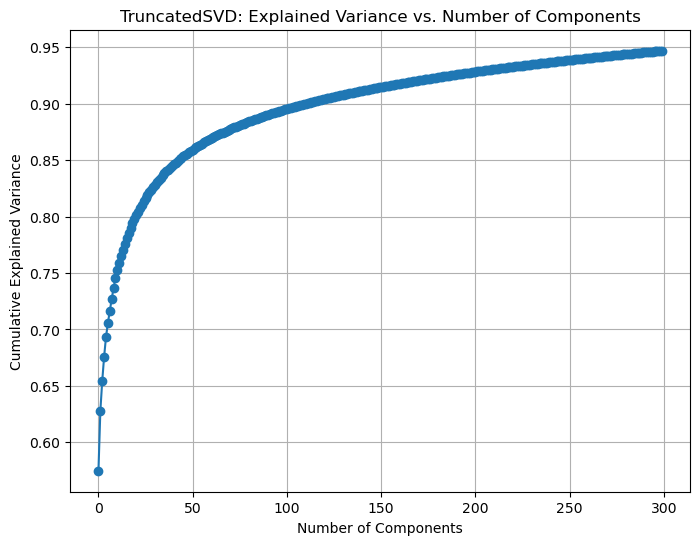

In [43]:
X_sparse = csr_matrix(np.array([vec for vec in movie_vectors_all.values()]))

# Обучаем SVD (на большое число компонент — например 300)
svd = TruncatedSVD(n_components=300, random_state=42)
X_reduced = svd.fit_transform(X_sparse)

# Строим график накопленной объяснённой дисперсии
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(svd.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('TruncatedSVD: Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()


In [46]:
lengths = [len(vec) for vec in movie_vectors_all.values()]
length_counts = Counter(lengths)
print("Распределение длин:", length_counts)

Распределение длин: Counter({1148: 86537})


In [47]:
# # Окончательная версия: использование 300 компонент для TruncatedSVD
# svd_final = TruncatedSVD(n_components=300, random_state=42)
# X_reduced_final = svd_final.fit_transform(X_sparse)

# # Сохраняем результат 
# with open('content/films/X_reduced_final.dill', 'wb') as f:
#     dill.dump(X_reduced_final, f)

# print(f"Обработано и сохранено {X_reduced_final.shape[0]} фильмов с {X_reduced_final.shape[1]} компонентами.")

Обработано и сохранено 86537 фильмов с 300 компонентами.


In [10]:
with open('content/films/X_reduced_final.dill', 'rb') as f:
    X_reduced_final = dill.load(f)


In [58]:
movie_id = 1  # Идентификатор фильма, для которого ищем похожие
similar_movies = recommend_similar_movies(movie_id, movies_df=movies, X_reduced_final=X_reduced_final, top_n=5)
print(similar_movies)

Общее количество векторов фильмов: 86537

Рекомендации для фильма: 'Toy Story (1995)'

                                    title  \
1965      Honey, I Shrunk the Kids (1989)   
14945               Knight and Day (2010)   
3338   Death Wish 4: The Crackdown (1987)   
1760                Borrowers, The (1997)   
4392                        D.O.A. (1988)   

                                         genres  similarity  
1965   Adventure|Children|Comedy|Fantasy|Sci-Fi    0.901724  
14945                     Action|Comedy|Romance    0.873002  
3338                               Action|Drama    0.871944  
1760          Adventure|Children|Comedy|Fantasy    0.868100  
4392                 Film-Noir|Mystery|Thriller    0.862770  


## 2. Попробуем поиск по KNN

Т.к KNN фактически K-means для поиска кол-ва кластеров всопльзуем методами локтя и силуэта

In [82]:
def recommend_similar_movies_knn(movie_id, movies_df, X_reduced_final, top_n=10):
    """
    Рекомендации по фильму с использованием KNN и пониженных векторов.
    """

     # Шаг 1: Получаем вектор для целевого фильма (по индексам в X_reduced_final)
    movie_vector = X_reduced_final[movie_id]
    
    # Получаем название фильма
    movie_title = movies_df.loc[movies_df['movieId'] == movie_id, 'title'].values[0]
    
    print(f"\nРекомендации для фильма: '{movie_title}'\n")
    
    # Шаг 2: Получаем вектор для целевого фильма
    movie_vector = X_reduced_final[movie_id]
    
    # Шаг 3: Используем KNN для поиска ближайших фильмов
    knn = NearestNeighbors(n_neighbors=top_n + 1, metric='cosine')  # Используем косинусное сходство
    knn.fit(X_reduced_final)
    
    # Шаг 4: Находим похожие фильмы
    distances, indices = knn.kneighbors([movie_vector])
    
    # Шаг 4: Получаем список похожих фильмов
    similar_movies = []
    for i in range(1, len(indices[0])):  # Начинаем с 1, чтобы исключить сам фильм
        similar_movie_id = movies_df.iloc[indices[0][i]]['movieId']
        similar_movie_title = movies_df.loc[movies_df['movieId'] == similar_movie_id, 'title'].values[0]
        similar_movies.append((similar_movie_title, distances[0][i]))

    return similar_movies

In [88]:
# Пример использования:
movie_id = 1  # Идентификатор фильма, для которого ищем похожие
similar_movies_knn = recommend_similar_movies_knn(movie_id, movies_df=movies, X_reduced_final=X_reduced_final, top_n=5)



Рекомендации для фильма: 'Toy Story (1995)'



In [86]:
recommendations_knn_df = pd.DataFrame(similar_movies_knn, columns=["Recommended Movie", "Similarity"])

In [87]:
recommendations_knn_df

,Recommended Movie,Similarity
0,"Honey, I Shrunk the Kids (1989)",0.098276
1,Knight and Day (2010),0.126998
2,Death Wish 4: The Crackdown (1987),0.128056
3,"Borrowers, The (1997)",0.131900
4,D.O.A. (1988),0.137230


## 3. Попробуем кластеризацию

In [89]:
X_reduced_final.shape

(86537, 300)

## Попробуем HDBSCAN

In [110]:
# Создаем объект кластеризатора HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)

# Применяем кластеризацию
clusters_all_hdbscan = clusterer.fit_predict(X_reduced_final)

# Получаем информацию о кластерах
print(f"Количество кластеров: {len(np.unique(clusters_all_hdbscan))}")
print(f"Количество шумовых точек (метка -1): {np.sum(clusters_all_hdbscan == -1)}")


Количество кластеров: 4
Количество шумовых точек (метка -1): 12820


In [115]:
with open('content/films/clusters_all_hdbscan.dill', 'wb') as f:
    dill.dump(clusters_all_hdbscan, f)

### Разбивка очнеь плохая нет смысла ее использовать

## Попробуем AgglomerativeClustering

In [113]:
# Шаг 1: Ресэмплинг данных
X_sample = resample(X_reduced_final, n_samples=20000, random_state=42)

# Иерархическая кластеризация на подмножестве данных
agg_clustering = AgglomerativeClustering(distance_threshold=0.5, n_clusters=None)
clusters_sample = agg_clustering.fit_predict(X_sample)

# Получаем ссылки на кластеры из агломеративного дерева
linkage_matrix = agg_clustering.children_

In [116]:
# Шаг 2: Применяем ближайших соседей для всех точек X_encod, чтобы найти кластер для каждой точки
# Найдем ближайших соседей для X_sample
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(X_sample)
distances, indices = nbrs.kneighbors(X_reduced_final)

# Теперь каждому элементу из X_encod мы присваиваем кластер ближайшего соседа из X_sample
clusters_all = clusters_sample[indices.flatten()]

In [117]:
# Получаем информацию о кластерах
print(f"Количество кластеров: {len(np.unique(clusters_all))}")
print(f"Количество шумовых точек (метка -1): {np.sum(clusters_all == -1)}")

Количество кластеров: 3469
Количество шумовых точек (метка -1): 0


In [140]:
def recommend_similar_movies_by_agglomerative_cluster(movie_id, movies_df, X_reduced_final, clusters_all, top_n=10):
    """
    Рекомендации по фильму с использованием агломеративной кластеризации и пониженных векторов.
    Фильмы выбираются из того же кластера, и сортируются по евклидовому расстоянию.
    """
    
    # Шаг 1: Получаем индекс фильма в movies_df по movieId
    movie_index = movies_df[movies_df['movieId'] == movie_id].index[0]  # Ищем индекс фильма по movieId
    movie_vector = X_reduced_final[movie_index]
    
    # Получаем название фильма
    movie_title = movies_df.loc[movies_df['movieId'] == movie_id, 'title'].values[0]
    
    print(f"\nРекомендации для фильма: '{movie_title}'\n")
    
    # Шаг 2: Находим кластер для целевого фильма
    target_cluster = clusters_all[movie_index]
    
    # Шаг 3: Находим все фильмы, которые принадлежат тому же кластеру
    cluster_indices = [i for i, cluster in enumerate(clusters_all) if cluster == target_cluster and i != movie_index]
    
    # Если кластер не содержит других фильмов, вернем None
    if len(cluster_indices) == 0:
        return None
    
    # Применяем фильтрацию индексов, чтобы избежать выхода за границы
    valid_cluster_indices = [i for i in cluster_indices if i < len(X_reduced_final)]
    
    # Если не найдено валидных индексов, возвращаем None
    if len(valid_cluster_indices) == 0:
        return None
    
    # Извлекаем все векторы фильмов в этом кластере
    cluster_vectors = X_reduced_final[valid_cluster_indices]
    
    # Вычисляем евклидово расстояние между целевым фильмом и всеми фильмами в кластере
    distances = euclidean_distances([movie_vector], cluster_vectors)[0]
    
    # Шаг 4: Создаем список фильмов с расстоянием
    similar_movies = []
    for i, dist in zip(valid_cluster_indices, distances):
        # Применяем iloc для получения данных по индексу
        similar_movie_id = movies_df.iloc[i]['movieId']
        similar_movie_title = movies_df.loc[movies_df['movieId'] == similar_movie_id, 'title'].values[0]
        similar_movies.append({
            'movieId': similar_movie_id,
            'title': similar_movie_title,
            'distance': dist
        })
    
    # Шаг 5: Преобразуем в DataFrame для удобного вывода и сортируем по расстоянию
    similar_movies_df = pd.DataFrame(similar_movies)
    similar_movies_df = similar_movies_df.sort_values(by='distance', ascending=True)  # Сортируем по возрастанию расстояния
    
    # Возвращаем топ-n рекомендаций
    return similar_movies_df.head(top_n)

,movieId,title,distance
0,3699,Starman (1984),6.158118
1,115019,"Yank on the Burma Road, A (1942)",8.728472
2,140799,Truck Turner (1974),8.728472
3,158031,The Little Theatre of Jean Renoir (1970),8.728472
4,205591,The Uninvited (2003),8.728472


In [157]:
movie_id = 1  # Например, фильм с индексом 1
recommended_movies = recommend_similar_movies_by_agglomerative_cluster(movie_id, movies_df=movies, X_reduced_final=X_reduced_final, clusters_all=clusters_all, top_n=5)
# Подтягиваем жанры для рекомендованных фильмов
recommended_movies['genres'] = recommended_movies['title'].apply(lambda title: movies[movies['title'] == title]['genres'].values[0])
# Выводим результат с жанрами
print(recommended_movies[['title', 'distance', 'genres']])



Рекомендации для фильма: 'Toy Story (1995)'

                                      title  distance  \
0                            Starman (1984)  6.158118   
1          Yank on the Burma Road, A (1942)  8.728472   
2                       Truck Turner (1974)  8.728472   
3  The Little Theatre of Jean Renoir (1970)  8.728472   
4                      The Uninvited (2003)  8.728472   

                           genres  
0  Adventure|Drama|Romance|Sci-Fi  
1                       Drama|War  
2              Action|Crime|Drama  
3              (no genres listed)  
4          Action|Horror|Thriller  


In [158]:
movie_id = 2  # Например, фильм с индексом 1
recommended_movies = recommend_similar_movies_by_agglomerative_cluster(movie_id, movies_df=movies, X_reduced_final=X_reduced_final, clusters_all=clusters_all, top_n=5)
# Подтягиваем жанры для рекомендованных фильмов
recommended_movies['genres'] = recommended_movies['title'].apply(lambda title: movies[movies['title'] == title]['genres'].values[0])
# Выводим результат с жанрами
print(recommended_movies[['title', 'distance', 'genres']])


Рекомендации для фильма: 'Jumanji (1995)'

                            title  distance              genres
0           Spare Bed-Room (1969)  6.688013  (no genres listed)
1                Blue Rita (1977)  6.688013     Action|Thriller
2  Come, Come, Come Upward (1989)  6.688013               Drama
3       I Wish I Had Wings (1932)  6.688013    Animation|Comedy


### Рекомендации очнеь инетресные но не коррелируют с другими методами

## User-based часть

. ALS (Alternating Least Squares)
Описание: Это метод для матричной факторизации, который используется в collaborative filtering. ALS пытается разложить матрицу пользователь-товар на два более маленьких матрицы (пользовательская и товарная). Метод использует чередующиеся минимизации, чтобы предсказать недостающие значения.

Преимущества: Хорошо работает, когда у вас есть много данных о взаимодействиях пользователей с объектами (например, рейтинги). ALS способен учитывать латентные факторы, которые могут влиять на предпочтения пользователей.

Недостатки: Требует большого объема данных для обучения, и может быть медленным при работе с большими датасетами.

2. KNN (k-Nearest Neighbors)
Описание: Этот метод используется для определения сходства между пользователями (или объектами) на основе их профилей (например, по схожести рейтингов или векторных представлений).

Как это работает для user-based: Мы находим ближайших соседей для конкретного пользователя, используя метрики сходства (например, косинусное расстояние, евклидово расстояние или корреляцию Пирсона). Затем на основе этих ближайших пользователей формируются рекомендации.

Преимущества: Прост в реализации и подходит для небольших или средних данных.

Недостатки: Может быть медленным для больших наборов данных, так как требует расчета сходства для каждого пользователя с каждым другим. Также не всегда хорошо работает с разреженными данными.

3. User-Item Matrix Factorization
Описание: Этот метод можно использовать, если ваша задача — факторизовать матрицу взаимодействий между пользователями и предметами. Например, вы можете использовать SVD (Singular Value Decomposition) для поиска скрытых факторов, которые объясняют взаимодействия.

Преимущества: Может работать с разреженными матрицами и хорошо подходит для использования с implicit feedback (например, просмотры или клики).

Недостатки: Потребует большого объема данных и может быть медленным на больших матрицах.

4. Matrix Factorization Using Neural Networks
Описание: В последние годы для рекомендательных систем стали применять нейронные сети для факторизации матрицы, обучая модель на реальных данных о пользователях и объектах. Это могут быть глубокие модели, например, autoencoders, которые пытаются восстановить разреженную матрицу.

Преимущества: Может быть более гибким и мощным, чем традиционные методы факторизации, такие как SVD.

Недостатки: Требует много вычислительных ресурсов для обучения и настройки.

5. Factorization Machines
Описание: Это общее обобщение матричной факторизации, которое может быть использовано для построения рекомендательных систем. Factorization Machines могут учитывать как взаимодействие пользователей с объектами, так и более сложные взаимодействия (например, с дополнительными признаками).

Преимущества: Позволяет работать с очень большими разреженными данными и учитывать взаимодействие дополнительных факторов.

Недостатки: Модели могут быть сложными для настройки и требуют большого объема вычислений.

6. Deep Learning Models for User-Based Recommendations
Описание: Глубокие нейронные сети могут быть использованы для моделирования предпочтений пользователей. Сеть обучается предсказывать, какие объекты могут быть интересны пользователю, принимая во внимание его прошлые действия и предпочтения.

Преимущества: Очень гибкие и могут извлекать сложные скрытые паттерны в данных.

Недостатки: Очень ресурсоёмкие и требуют большого объема данных для тренировки.

7. Content-Based Filtering
Описание: Это подход, при котором рекомендации делаются на основе контента, с которым пользователь взаимодействовал. Например, для фильма — это описание, жанры, теги и т.д. Хотя это не является полностью user-based методом, его можно комбинировать с другими подходами.

Преимущества: Прост в реализации и не требует данных о поведении других пользователей.

Недостатки: Проблемы с разнообразием рекомендаций — пользователь может получать только фильмы, похожие на те, которые он уже смотрел.

8. Hybrid Models
Описание: Это комбинация различных методов рекомендаций, например, collaborative filtering и content-based filtering. Например, можно использовать ALS для рекомендаций и KNN для анализа сходства между пользователями.

Преимущества: Гибкость и возможность использовать сильные стороны различных подходов.

Недостатки: Сложность в реализации и настройке.

In [21]:
def build_user_vector(user_ratings, movie_vectors, good_rating_threshold):
    """
    Функция для построения user_vector, на основе оценок пользователя.
    Для каждой оценки фильма будет назначен вес в зависимости от рейтинга.
    """
    # Берем размерность вектора фильма
    movie_vector_sample = next(iter(movie_vectors.values()))  # Берем первый вектор из словаря
    user_vector = np.zeros(len(movie_vector_sample))  # Инициализируем нулевой вектор, размерность как у movie_vectors
    total_weight = 0
    
    for _, row in user_ratings.iterrows():
        movie_id = row['movieId']
        rating = row['rating']
        weight = 0
        
        if rating >= 4:
            weight = 1  # Положительный рейтинг увеличивает вклад
        elif rating <= 2:
            weight = -1  # Негативный рейтинг уменьшает вклад
        else:
            weight = 0  # Нейтральный рейтинг не изменяет вклад
        
        if movie_id in movie_vectors:
            user_vector += weight * movie_vectors[movie_id]  # Суммируем вес вектора
            total_weight += weight
    
    if total_weight != 0:
        user_vector /= total_weight  # Нормализуем вектор пользователя
    return user_vector

In [22]:
def calculate_similarity(movie_vector, user_vector):
    """
    Расчет схожести между вектором фильма и вектором пользователя.
    """
    return np.dot(movie_vector, user_vector)  # Косинусная схожесть или другой метод

def apply_sports_weight(ranking):
    """
    Применяем спортивную систему весов для позиций (по аналогии с Формулой 1).
    """
    weights = {1: 20, 2: 12, 3: 8, 4: 6, 5: 4, 6: 2}  # Примерная система весов 
    
    # Применяем веса для каждого места в рейтинге
    weighted_ranking = {}
    for idx, rank in enumerate(ranking):
        place = idx + 1  # Номер места
        if place in weights:
            weighted_ranking[rank['movieId']] = weighted_ranking.get(rank['movieId'], 0) + weights[place]
    
    return weighted_ranking


def get_user_recommendations_by_rating(user_id, ratings, movie_ids_order, movie_vectors, top_n=5, good_rating_threshold=4, max_genre_reduction_steps=5):
    # Получаем оценки пользователя
    user_ratings = ratings[ratings['userId'] == user_id]
    
    # Объединяем с таблицей movies, чтобы добавить информацию о жанрах
    user_ratings_with_genres = user_ratings.merge(movies[['movieId', 'genres']], on='movieId', how='left')
    
    # Подсчитаем количество хороших оценок
    num_good_ratings = user_ratings_with_genres[user_ratings_with_genres['rating'] >= good_rating_threshold].shape[0]
    num_ratings = user_ratings_with_genres.shape[0]
    
    print(f"[INFO] У пользователя {user_id} {num_ratings} оценок, из них {num_good_ratings} хороших.", end=" ")

    # Проверяем условие для использования адаптации веса жанров
    if (num_ratings < 5) or (num_ratings > 5 and num_good_ratings < 3):
        print("Используем адаптацию веса жанров.")
        
        recommendations = []
        all_genres = []  # Список для всех жанров
        for _, row in user_ratings_with_genres.iterrows():
            movie_rating = row['rating']
            movie_id = row['movieId']
            movie_genres = row['genres'].split('|')  # Жанры разделены символом '|'
            all_genres.extend(movie_genres)  # Добавляем жанры в общий список
            movie_vector = movie_vectors.get(movie_id, None)
            
            if movie_vector is not None:
                # Модифицируем веса жанров на основе оценки
                if movie_rating >= 4:  # Если оценка хорошая (4 или больше)
                    print(f"[INFO] Оценка хорошая для фильма {movie_id}, усиливаем веса для жанров: {movie_genres}")
                    weight_factor = 1.5  # Усиливаем веса
                else:  # Если оценка плохая (менее 4)
                    print(f"[INFO] Оценка плохая для фильма {movie_id}, ослабляем веса для жанров: {movie_genres}")
                    weight_factor = 0.5  # Ослабляем веса

                # Обновляем веса для жанров в movie_vectors
                for genre in movie_genres:
                    if genre in movie_vector:
                        movie_vector[genre] *= weight_factor  # Усиливаем или ослабляем соответствующий вес
                
                recommendations.append({'movieId': movie_id, 'similarity': np.dot(movie_vector, movie_vector)})

        # Сортируем рекомендации по схожести
        recommendations = sorted(recommendations, key=lambda x: x['similarity'], reverse=True)
        
        # Проверяем, если количество рекомендаций меньше 5
        if len(recommendations) < top_n:
            print(f"[INFO] Недостаточно рекомендаций с текущими жанрами, уменьшаем количество жанров.")
            
            # Уменьшаем количество жанров, начиная с самых общих
            reduced_genres_list = list(set(all_genres))  # Получаем уникальные жанры
            additional_recommendations = []
            steps = 0

            while len(reduced_genres_list) > 0 and len(additional_recommendations) < top_n and steps < max_genre_reduction_steps:
                # Попробуем сделать рекомендации с уменьшением жанров
                for i in range(1, len(reduced_genres_list) + 1):
                    reduced_genres = reduced_genres_list[:i]
                    # Фильтруем фильмы, которые имеют хотя бы один из этих жанров
                    possible_movies = movies[movies['genres'].str.contains('|'.join(reduced_genres))]
                    for _, row in possible_movies.iterrows():
                        movie_id = row['movieId']
                        movie_genres = row['genres'].split('|')
                        
                        if movie_id not in [rec['movieId'] for rec in additional_recommendations]:  # Убираем дубли
                            movie_vector = movie_vectors.get(movie_id, None)
                            if movie_vector is not None:
                                similarity = np.dot(movie_vector, movie_vector)
                                additional_recommendations.append({'movieId': movie_id, 'similarity': similarity})

                # Если у нас достаточно рекомендаций, выходим из цикла
                if len(additional_recommendations) >= top_n:
                    recommendations = additional_recommendations[:top_n]
                    break

                steps += 1  # Увеличиваем счетчик шагов

            # Если все шаги исчерпаны и рекомендаций все равно недостаточно
            if len(recommendations) < top_n:
                print("[INFO] Достигнут максимальный лимит шагов по уменьшению жанров.")
                recommendations = additional_recommendations[:top_n]

            # Сортируем рекомендации по схожести
            recommendations = sorted(recommendations, key=lambda x: x['similarity'], reverse=True)[:top_n]

    else:
        print("Используем только user_vector.")
        # В другом случае, если оценок больше, строим полноценный user_vector
        user_vector = build_user_vector(user_ratings_with_genres, movie_vectors, good_rating_threshold)
        
        recommendations = []
        
        for movie_id in movie_ids_order:
            movie_vector = movie_vectors.get(movie_id, None)
            if movie_vector is not None:
                similarity = calculate_similarity(movie_vector, user_vector)
                recommendations.append({'movieId': movie_id, 'similarity': similarity})

        # Сортируем рекомендации по схожести
        recommendations = sorted(recommendations, key=lambda x: x['similarity'], reverse=True)

        # Ограничиваем топ N рекомендаций
        recommendations = recommendations[:top_n]

    return recommendations


In [137]:
movie_ids_order = movies['movieId'].sample(n=10, random_state=42).tolist()

In [138]:
movie_ids_order

[189019, 268374, 134021, 177245, 45730, 109798, 137763, 189315, 141387, 163995]

In [147]:
user_id = 1  # Например, фильм с индексом 1
recommended_movies = get_user_recommendations_by_rating(
    user_id, 
    ratings=ratings, 
    movie_ids_order=movie_ids_order, 
    movie_vectors=movie_vectors_all, 
    top_n=5)

# Преобразуем список рекомендаций в DataFrame
df_recommended = pd.DataFrame(recommended_movies, columns=['movieId'])

# Объединяем DataFrame с рекомендациями с DataFrame с фильмами по movieId
df_recommended = pd.merge(df_recommended, movies, on='movieId')

# Выводим финальный результат
df_recommended

[INFO] У пользователя 1 62 оценок, из них 41 хороших. Используем только user_vector.


,movieId,title,genres
0,45730,Lady in the Water (2006),Drama|Fantasy|Mystery
1,134021,5 to 7 (2014),Comedy|Drama|Romance
2,189019,The Rape of Recy Taylor (2017),Documentary
3,268374,Moonlight Shadow (2021),Drama
4,177245,Same Kind of Different as Me (2017),Drama


In [145]:
user_id = 148385  # Например, пользователь с индексом 1
recommended_movies = get_user_recommendations_by_rating(
    user_id, 
    ratings=ratings, 
    movie_ids_order=movie_ids_order, 
    movie_vectors=movie_vectors_all, 
    top_n=5)

# Преобразуем список рекомендаций в DataFrame
df_recommended = pd.DataFrame(recommended_movies, columns=['movieId'])

# Объединяем DataFrame с рекомендациями с DataFrame с фильмами по movieId
df_recommended = pd.merge(df_recommended, movies, on='movieId')

# Выводим финальный результат
df_recommended

[INFO] У пользователя 148385 1 оценок, из них 1 хороших. Используем адаптацию веса жанров.
[INFO] Оценка хорошая для фильма 1196, усиливаем веса для жанров: ['Action', 'Adventure', 'Sci-Fi']
[INFO] Недостаточно рекомендаций с текущими жанрами, уменьшаем количество жанров.


,movieId,title,genres
0,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
1,29,"City of Lost Children, The (Cité des enfants perdus, La) (1995)",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,76,Screamers (1995),Action|Sci-Fi|Thriller
3,24,Powder (1995),Drama|Sci-Fi
4,66,Lawnmower Man 2: Beyond Cyberspace (1996),Action|Sci-Fi|Thriller


## Попробуем метод KNN

Сначала нужно получить общий вектор пользователей

In [15]:
def process_movies_in_chunks(movies_df, genome_scores, all_genres, user_ratings,
                             chunk_count=5, good_rating_threshold=4):
    total_movies = len(movies_df)
    chunk_size = total_movies // chunk_count

    movie_vectors = {}
    user_vectors = {}

    # Индексация тегов
    tag_set = sorted(genome_scores['tagId'].unique())
    tag_index = {tag: i for i, tag in enumerate(tag_set)}
    tag_vector_len = len(tag_index)

    print(f"[INFO] Всего фильмов: {total_movies}, обработка в {chunk_count} частях...")

    for i in range(chunk_count):
        start_idx = i * chunk_size
        end_idx = (i + 1) * chunk_size if i < chunk_count - 1 else total_movies
        batch = movies_df.iloc[start_idx:end_idx]

        print(f"\n[CHUNK {i+1}] Обработка фильмов {start_idx}–{end_idx}...")

        try:
            batch_movie_vectors, batch_user_vectors = process_batch_with_user_vectors(
                batch, all_genres, genome_scores, tag_index, tag_vector_len, user_ratings, good_rating_threshold
            )
            movie_vectors.update(batch_movie_vectors)
            user_vectors.update(batch_user_vectors)
            print(f"[CHUNK {i+1}] Готово: {len(batch_movie_vectors)} фильмов, {len(batch_user_vectors)} пользователей")
        except Exception as e:
            print(f"[CHUNK {i+1}] Ошибка: {e}")

    return movie_vectors, user_vectors

In [16]:
def process_batch_with_user_vectors(batch, all_genres, genome_scores, tag_index, tag_vector_len, user_ratings, good_rating_threshold=4):
    try:
        # Инициализация векторов тегов и жанров
        genre_df = create_genre_vector(batch, all_genres)
        tag_vectors = {}

        print(f"[INFO] Генерация tag-векторов для {len(batch)} фильмов...")
        for movieId in tqdm(batch['movieId'], desc="Tag-векторы"):
            tag_vectors[movieId] = create_tag_vector(movieId, genome_scores, tag_index, tag_vector_len)

        movie_vectors = {}
        user_vectors = {}

        print(f"[INFO] Генерация movie-векторов...")
        for movieId in tqdm(batch['movieId'], desc="Movie-векторы"):
            genre_vector = genre_df.loc[movieId].values
            tag_vector = tag_vectors[movieId].toarray().flatten()
            movie_vectors[movieId] = np.concatenate([genre_vector, tag_vector])

        print(f"[INFO] Фильтрация рейтингов по batch-фильмам...")
        batch_movie_ids = set(batch['movieId'])
        user_ratings_in_batch = user_ratings[user_ratings['movieId'].isin(batch_movie_ids)]

        print(f"[INFO] Генерация user-векторов...")
        grouped_user_ratings = user_ratings_in_batch.groupby('userId')
        for user_id, group in tqdm(grouped_user_ratings, desc="User-векторы"):
            user_vector = process_user(user_id, group, movie_vectors, good_rating_threshold)
            user_vectors[user_id] = user_vector

        return movie_vectors, user_vectors
    except Exception as e:
        print(f"[ERROR] Ошибка при обработке batch: {e}")
        raise e

In [17]:
def process_user(user_id, user_ratings_for_movie, movie_vectors, good_rating_threshold):
    if not movie_vectors:
        return csr_matrix([])

    vector_len = len(next(iter(movie_vectors.values())))
    user_vector = np.zeros(vector_len)

    for _, row in user_ratings_for_movie.iterrows():
        movieId = row['movieId']
        rating = row['rating']
        if movieId in movie_vectors and rating >= good_rating_threshold:
            weight = rating / 5.0
            user_vector += movie_vectors[movieId] * weight

    return csr_matrix(user_vector)


In [19]:
movie_vectors, user_vectors = process_movies_in_chunks(
    movies_df=movies,
    genome_scores=genome_scores,
    all_genres=all_genres,
    user_ratings=ratings,
    chunk_count=10,  # или 10, если хочешь поменьше нагрузку
    good_rating_threshold=4
)


[INFO] Всего фильмов: 86537, обработка в 10 частях...

[CHUNK 1] Обработка фильмов 0–8653...
[INFO] Генерация tag-векторов для 8653 фильмов...


Tag-векторы: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8653/8653 [06:31<00:00, 22.09it/s]


[INFO] Генерация movie-векторов...


Movie-векторы: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8653/8653 [00:00<00:00, 20129.25it/s]


[INFO] Фильтрация рейтингов по batch-фильмам...
[INFO] Генерация user-векторов...


User-векторы: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 326228/326228 [14:15<00:00, 381.43it/s]


[CHUNK 1] Готово: 8653 фильмов, 326228 пользователей

[CHUNK 2] Обработка фильмов 8653–17306...
[INFO] Генерация tag-векторов для 8653 фильмов...


Tag-векторы: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8653/8653 [04:34<00:00, 31.52it/s]


[INFO] Генерация movie-векторов...


Movie-векторы: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8653/8653 [00:00<00:00, 26688.14it/s]


[INFO] Фильтрация рейтингов по batch-фильмам...
[INFO] Генерация user-векторов...


User-векторы: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155883/155883 [03:21<00:00, 774.68it/s]


[CHUNK 2] Готово: 8653 фильмов, 155883 пользователей

[CHUNK 3] Обработка фильмов 17306–25959...
[INFO] Генерация tag-векторов для 8653 фильмов...


Tag-векторы: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8653/8653 [03:22<00:00, 42.69it/s]


[INFO] Генерация movie-векторов...


Movie-векторы: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8653/8653 [00:00<00:00, 26920.67it/s]


[INFO] Фильтрация рейтингов по batch-фильмам...
[INFO] Генерация user-векторов...


User-векторы: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96980/96980 [01:26<00:00, 1124.59it/s]


[CHUNK 3] Готово: 8653 фильмов, 96980 пользователей

[CHUNK 4] Обработка фильмов 25959–34612...
[INFO] Генерация tag-векторов для 8653 фильмов...


Tag-векторы: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8653/8653 [02:52<00:00, 50.22it/s]


[INFO] Генерация movie-векторов...


Movie-векторы: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8653/8653 [00:00<00:00, 29481.23it/s]


[INFO] Фильтрация рейтингов по batch-фильмам...
[INFO] Генерация user-векторов...


User-векторы: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59202/59202 [00:27<00:00, 2147.13it/s]


[CHUNK 4] Готово: 8653 фильмов, 59202 пользователей

[CHUNK 5] Обработка фильмов 34612–43265...
[INFO] Генерация tag-векторов для 8653 фильмов...


Tag-векторы: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8653/8653 [02:43<00:00, 52.84it/s]


[INFO] Генерация movie-векторов...


Movie-векторы: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8653/8653 [00:00<00:00, 27438.91it/s]


[INFO] Фильтрация рейтингов по batch-фильмам...
[INFO] Генерация user-векторов...


User-векторы: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47483/47483 [00:19<00:00, 2389.74it/s]


[CHUNK 5] Готово: 8653 фильмов, 47483 пользователей

[CHUNK 6] Обработка фильмов 43265–51918...
[INFO] Генерация tag-векторов для 8653 фильмов...


Tag-векторы: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8653/8653 [02:52<00:00, 50.24it/s]


[INFO] Генерация movie-векторов...


Movie-векторы: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8653/8653 [00:00<00:00, 27806.94it/s]


[INFO] Фильтрация рейтингов по batch-фильмам...
[INFO] Генерация user-векторов...


User-векторы: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44628/44628 [00:23<00:00, 1869.56it/s]


[CHUNK 6] Готово: 8653 фильмов, 44628 пользователей

[CHUNK 7] Обработка фильмов 51918–60571...
[INFO] Генерация tag-векторов для 8653 фильмов...


Tag-векторы: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8653/8653 [02:47<00:00, 51.57it/s]


[INFO] Генерация movie-векторов...


Movie-векторы: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8653/8653 [00:00<00:00, 25349.57it/s]


[INFO] Фильтрация рейтингов по batch-фильмам...
[INFO] Генерация user-векторов...


User-векторы: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33488/33488 [00:17<00:00, 1917.50it/s]


[CHUNK 7] Готово: 8653 фильмов, 33488 пользователей

[CHUNK 8] Обработка фильмов 60571–69224...
[INFO] Генерация tag-векторов для 8653 фильмов...


Tag-векторы: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8653/8653 [02:41<00:00, 53.72it/s]


[INFO] Генерация movie-векторов...


Movie-векторы: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8653/8653 [00:00<00:00, 26311.13it/s]


[INFO] Фильтрация рейтингов по batch-фильмам...
[INFO] Генерация user-векторов...


User-векторы: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28798/28798 [00:14<00:00, 1955.09it/s]


[CHUNK 8] Готово: 8653 фильмов, 28798 пользователей

[CHUNK 9] Обработка фильмов 69224–77877...
[INFO] Генерация tag-векторов для 8653 фильмов...


Tag-векторы: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8653/8653 [02:35<00:00, 55.73it/s]


[INFO] Генерация movie-векторов...


Movie-векторы: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8653/8653 [00:00<00:00, 25486.20it/s]


[INFO] Фильтрация рейтингов по batch-фильмам...
[INFO] Генерация user-векторов...


User-векторы: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15345/15345 [00:06<00:00, 2249.66it/s]


[CHUNK 9] Готово: 8653 фильмов, 15345 пользователей

[CHUNK 10] Обработка фильмов 77877–86537...
[INFO] Генерация tag-векторов для 8660 фильмов...


Tag-векторы: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8660/8660 [02:35<00:00, 55.85it/s]


[INFO] Генерация movie-векторов...


Movie-векторы: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8660/8660 [00:00<00:00, 25410.78it/s]


[INFO] Фильтрация рейтингов по batch-фильмам...
[INFO] Генерация user-векторов...


User-векторы: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11618/11618 [00:05<00:00, 2067.86it/s]

[CHUNK 10] Готово: 8660 фильмов, 11618 пользователей


In [13]:

def save_dict_in_chunks(data_dict, output_dir, base_filename="data", chunk_size=10000):
    """
    Универсальная функция для сохранения словаря по чанкам.

    :param data_dict: словарь для сохранения
    :param output_dir: папка, куда будут сохранены чанки
    :param base_filename: базовое имя файлов (например, "user_vectors" или "movie_vectors")
    :param chunk_size: размер одного чанка
    """
    os.makedirs(output_dir, exist_ok=True)

    keys = list(data_dict.keys())
    total = len(keys)

    print(f"[INFO] Сохраняем {total} элементов по чанкам в '{output_dir}'...")

    for i in tqdm(range(0, total, chunk_size)):
        chunk_keys = keys[i:i + chunk_size]
        chunk_data = {k: data_dict[k] for k in chunk_keys}

        chunk_filename = os.path.join(output_dir, f"{base_filename}_chunk_{i // chunk_size + 1}.dill")
        with open(chunk_filename, 'wb') as f:
            dill.dump(chunk_data, f)

    print(f"[✅] Всего чанков сохранено: {(total + chunk_size - 1) // chunk_size}")

In [14]:
def load_dict_from_chunks(chunk_dir, base_filename="data"):
    """
    Загружает словарь, сохранённый по чанкам, и объединяет все части.

    :param chunk_dir: путь к папке с чанками
    :param base_filename: базовое имя файлов (например, "user_vectors" или "movie_vectors")
    :return: объединённый словарь
    """
    import dill
    import os
    from tqdm import tqdm

    data_dict = {}
    chunk_files = sorted([
        f for f in os.listdir(chunk_dir)
        if f.startswith(base_filename) and f.endswith('.dill')
    ])

    print(f"[INFO] Загружаем {len(chunk_files)} чанков из '{chunk_dir}'...")

    for chunk_file in tqdm(chunk_files):
        chunk_path = os.path.join(chunk_dir, chunk_file)
        with open(chunk_path, 'rb') as f:
            chunk_data = dill.load(f)
            data_dict.update(chunk_data)

    print("[✅] Все чанки успешно загружены.")
    return data_dict

In [21]:
# # Сохраняем user_vectors
# save_dict_in_chunks(user_vectors, output_dir='content/films/user_vectors_chank', base_filename='user_vectors', chunk_size=10000)


[INFO] Сохраняем 330975 элементов по чанкам в 'content/films/user_vectors_chank'...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [01:19<00:00,  2.33s/it]

[✅] Всего чанков сохранено: 34


In [20]:
# save_dict_in_chunks(movie_vectors, output_dir='content/films/movie_vectors_chank', base_filename='movie_vectors', chunk_size=10000)

[INFO] Сохраняем 86537 элементов по чанкам в 'content/films/movie_vectors_chank'...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.53it/s]

[✅] Всего чанков сохранено: 9


In [15]:
# Загрузка user_vectors
user_vectors = load_dict_from_chunks('content/films/user_vectors_chank', base_filename='user_vectors')

# Загрузка movie_vectors
movie_vectors = load_dict_from_chunks('content/films/movie_vectors_chank', base_filename='movie_vectors')

[INFO] Загружаем 34 чанков из 'content/films/user_vectors_chank'...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:43<00:00,  1.27s/it]


[✅] Все чанки успешно загружены.
[INFO] Загружаем 9 чанков из 'content/films/movie_vectors_chank'...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.34s/it]

[✅] Все чанки успешно загружены.


In [23]:
def combine_user_movie_vectors_in_chunks(user_vectors, movie_vectors, chunk_size=1000):
    """
    Объединяет user_vector с каждым movie_vector для чанков данных.
    """
    movie_ids = list(movie_vectors.keys())
    total_movies = len(movie_ids)
    
    common_vectors = []
    
    # Размерность векторов
    vector_dim = len(next(iter(movie_vectors.values())))  # размерность movie-вектора
    user_dim = len(next(iter(user_vectors.values()))[0].toarray().flatten())  # размерность user-вектора
    
    # Обработка векторов по частям (чанкам)
    for start_idx in range(0, total_movies, chunk_size):
        end_idx = min(start_idx + chunk_size, total_movies)
        batch_movie_ids = movie_ids[start_idx:end_idx]
        
        # Генерация объединённых векторов для текущего чанка
        for movie_id in batch_movie_ids:
            movie_vec = movie_vectors[movie_id]
            user_vec = user_vectors.get(movie_id)
        
            if user_vec is not None:
                user_vec = user_vec.toarray().flatten()  # Преобразуем разреженную матрицу в массив
            else:
                user_vec = np.zeros(user_dim)  # Если нет user-вектора, создаём нулевой
    
            combined = np.concatenate([movie_vec, user_vec])
            common_vectors.append(combined)
    
    # Преобразуем в список векторов в numpy массив
    X_combined = np.array(common_vectors)
    return X_combined

In [25]:
X_combined = combine_user_movie_vectors_in_chunks(user_vectors, movie_vectors, 1000)

In [28]:
X_combined.shape

(86537, 2298)

In [16]:
# Путь к файлу
compressed_path = 'content/films/X_combined_compressed.npz'

In [30]:
# # Сохраняем с компрессией
# np.savez_compressed(compressed_path, X=X_combined)
# print(f"[✔] Сжатый X_combined сохранён: {compressed_path}")

[✔] Сжатый X_combined сохранён: content/films/X_combined_compressed.npz


In [17]:
# Загружаем
loaded_data = np.load(compressed_path)
X_combined = loaded_data['X']
print(f"[ℹ️] Загружен массив формы: {X_combined.shape}")

NameError: name 'X_loaded' is not defined

In [46]:
def reduce_dimensionality_incremental(
    X_matrix,
    save_path,
    n_components=300,
    batch_size=2000,
    plot_variance=True
):
    """
    Понижает размерность матрицы X_matrix с помощью IncrementalPCA по чанкам.
    Сохраняет результат в .npz файл и строит график накопленной дисперсии (по необходимости).
    Поддерживает вход в виде словаря с csr_matrix.
    """
    # Если словарь — собрать в список
    if isinstance(X_matrix, dict):
        print("[INFO] Преобразуем словарь с разрежёнными матрицами в плотную матрицу...")
        X_matrix = np.array([vec.toarray().flatten() for vec in X_matrix.values()])
    
    elif hasattr(X_matrix, "toarray"):  # если это csr_matrix целиком
        print("[INFO] Преобразуем csr_matrix в плотную матрицу...")
        X_matrix = X_matrix.toarray()

    print(f"[INFO] Начало обучения IncrementalPCA (n_components={n_components}, batch_size={batch_size})...")
    ipca = IncrementalPCA(n_components=n_components)

    # Первый проход — обучение
    for i in tqdm(range(0, X_matrix.shape[0], batch_size), desc="Обучение IncrementalPCA"):
        batch = X_matrix[i:i+batch_size]
        ipca.partial_fit(batch)

    # Дисперсия
    cumulative_variance = np.cumsum(ipca.explained_variance_ratio_)
    n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
    print(f"[INFO] Чтобы объяснить ≥95% дисперсии, нужно {n_components_95} компонент.")

    if plot_variance:
        plt.figure(figsize=(8, 6))
        plt.plot(cumulative_variance, marker='o')
        plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title("IncrementalPCA: Explained Variance vs Components")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Второй проход — трансформация
    X_reduced = []
    for i in tqdm(range(0, X_matrix.shape[0], batch_size), desc="Трансформация"):
        batch = X_matrix[i:i+batch_size]
        X_reduced.append(ipca.transform(batch))

    X_reduced = np.vstack(X_reduced)
    print(f"[INFO] Готово: новая форма матрицы: {X_reduced.shape}")

    # Сохраняем результат
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    np.savez_compressed(save_path, X_reduced=X_reduced)
    print(f"[SAVED] Сохранено в файл: {save_path}")

    return X_reduced, ipca.explained_variance_ratio_, cumulative_variance

[INFO] Начало обучения IncrementalPCA (n_components=150, batch_size=2000)...


Обучение IncrementalPCA: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [02:28<00:00,  3.39s/it]

[INFO] Чтобы объяснить ≥95% дисперсии, нужно 1 компонент.


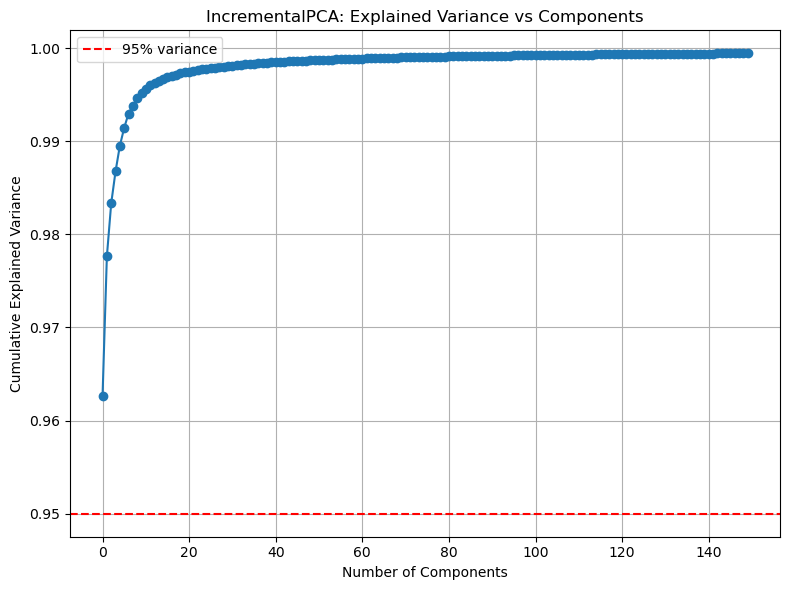

Трансформация: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 50.74it/s]


[INFO] Готово: новая форма матрицы: (86537, 150)
[SAVED] Сохранено в файл: content/films/X_combined_reduced.npz


In [43]:
X_reduced, evr, cumulative = reduce_dimensionality_incremental(
    X_combined,
    save_path="content/films/X_combined_reduced.npz",
    n_components=150
)

In [31]:
X_reduced.shape

(86537, 150)

## Попробуем KNN

In [33]:
def compute_knn_in_chunks(X_reduced, chunk_size=10000, n_neighbors=5):
    """
    Выполняет поиск ближайших соседей для данных X_reduced с использованием чанков.
    """
    total_samples = X_reduced.shape[0]
    all_neighbors = []
    all_distances = []
    
    # Создаём объект для поиска ближайших соседей
    knn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto', n_jobs=-1)
    
    # Обработка по чанкам
    for start_idx in range(0, total_samples, chunk_size):
        end_idx = min(start_idx + chunk_size, total_samples)
        chunk = X_reduced[start_idx:end_idx]
        
        print(f"[INFO] Обрабатываем чанк {start_idx} - {end_idx}")
        
        # Обучаем модель KNN для текущего чанка
        knn.fit(chunk)
        
        # Находим ближайших соседей для текущего чанка
        distances, indices = knn.kneighbors(chunk)
        
        # Добавляем результаты
        all_neighbors.append(indices)
        all_distances.append(distances)
    
    # Конкатенируем все чанки в один массив
    all_neighbors = np.concatenate(all_neighbors, axis=0)
    all_distances = np.concatenate(all_distances, axis=0)
    
    return all_neighbors, all_distances

In [39]:
def get_recommendations_df(user_id, ratings, movies, all_neighbors, all_distances, top_n=10):
    """
    Получает рекомендации для пользователя в виде DataFrame с жанрами и рейтингами от соседей.
    """
    user_idx = user_id  # Предполагается, что user_id совпадает с индексом в X_reduced

    neighbors = all_neighbors[user_idx]
    distances = all_distances[user_idx]

    recommended_movies = {}
    
    for i, neighbor_idx in enumerate(neighbors):
        neighbor_ratings = ratings[ratings['userId'] == neighbor_idx]
        
        for _, row in neighbor_ratings.iterrows():
            movie_id = row['movieId']
            rating = row['rating']
            
            if movie_id not in recommended_movies:
                recommended_movies[movie_id] = []
            recommended_movies[movie_id].append(rating)
    
    # Формируем список средних оценок
    movie_avg_ratings = [
        (movie_id, np.mean(ratings_list)) 
        for movie_id, ratings_list in recommended_movies.items()
    ]

    # Сортировка по убыванию средней оценки
    movie_avg_ratings.sort(key=lambda x: x[1], reverse=True)

    # Отбор top-N фильмов
    top_movies = movie_avg_ratings[:top_n]

    # Преобразуем в DataFrame
    top_movie_ids = [movie_id for movie_id, _ in top_movies]
    avg_ratings = {movie_id: avg_rating for movie_id, avg_rating in top_movies}
    
    recommendations_df = movies[movies['movieId'].isin(top_movie_ids)].copy()
    recommendations_df["avg_rating_from_neighbors"] = recommendations_df["movieId"].map(avg_ratings)
    
    # Сортируем DataFrame по рейтингу от соседей
    recommendations_df = recommendations_df.sort_values("avg_rating_from_neighbors", ascending=False).reset_index(drop=True)

    return recommendations_df

In [34]:
all_neighbors, all_distances = compute_knn_in_chunks(X_reduced, chunk_size=10000, n_neighbors=5)


[INFO] Обрабатываем чанк 0 - 10000
[INFO] Обрабатываем чанк 10000 - 20000
[INFO] Обрабатываем чанк 20000 - 30000
[INFO] Обрабатываем чанк 30000 - 40000
[INFO] Обрабатываем чанк 40000 - 50000
[INFO] Обрабатываем чанк 50000 - 60000
[INFO] Обрабатываем чанк 60000 - 70000
[INFO] Обрабатываем чанк 70000 - 80000
[INFO] Обрабатываем чанк 80000 - 86537


In [40]:
top_n = 10
user_id = 1  # например, первый пользователь

recs_df = get_recommendations_df(user_id, ratings, movies, all_neighbors, all_distances, top_n)
recs_df

,movieId,title,genres,avg_rating_from_neighbors
0,1036,Die Hard (1988),Action|Crime|Thriller,5.0
1,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure,5.0
2,2028,Saving Private Ryan (1998),Action|Drama|War,5.0
3,2762,"Sixth Sense, The (1999)",Drama|Horror|Mystery,5.0
4,3578,Gladiator (2000),Action|Adventure|Drama,5.0
5,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,5.0
6,4995,"Beautiful Mind, A (2001)",Drama|Romance,5.0
7,7153,"Lord of the Rings: The Return of the King, The (2003)",Action|Adventure|Drama|Fantasy,5.0
8,8132,Gladiator (1992),Action|Drama,5.0
9,8533,"Notebook, The (2004)",Drama|Romance,5.0


## Попробуем ALS
Вначале нудно понизитьразмерность для базовых векторов

In [ ]:
def reduce_dimensionality_sparse_svd(
    X_sparse_dict,
    save_path,
    n_components=150,
    plot_variance=True
):
    """
    Экономный по памяти способ понижения размерности sparse-векторов с помощью TruncatedSVD.
    Поддерживает входной словарь csr_matrix-векторов.
    """
    print("[INFO] Сборка sparse матрицы из словаря...")
    X_sparse = vstack(list(X_sparse_dict.values()))
    
    print(f"[INFO] Начало TruncatedSVD (n_components={n_components})...")
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_reduced = svd.fit_transform(X_sparse)

    cumulative_variance = np.cumsum(svd.explained_variance_ratio_)
    n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
    print(f"[INFO] Чтобы объяснить ≥95% дисперсии, нужно {n_components_95} компонент.")

    if plot_variance:
        plt.figure(figsize=(8, 6))
        plt.plot(cumulative_variance, marker='o')
        plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title("TruncatedSVD: Explained Variance vs Components")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    print(f"[INFO] Итоговая форма: {X_reduced.shape}")
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    np.savez_compressed(save_path, X_reduced=X_reduced)
    print(f"[SAVED] Сохранено: {save_path}")

    return X_reduced, svd.explained_variance_ratio_, cumulative_variance

In [32]:
def reduce_dimensionality_sparse_incremental(
    X_sparse_dict,
    save_path,
    n_components=150,
    batch_size=2000,
    plot_variance=True
):
    """
    Поинжение размерности для user_vector
    Батчевое понижение размерности sparse-векторов (в словаре) с помощью IncrementalPCA.
    Преобразует данные по чанкам, экономно использует память.
    """
    print(f"[INFO] Преобразуем словарь sparse векторов (n_components={n_components}, batch_size={batch_size})")

    ipca = IncrementalPCA(n_components=n_components)

    keys = list(X_sparse_dict.keys())
    
    # Первый проход — обучение
    print("[INFO] Этап partial_fit:")
    for i in tqdm(range(0, len(keys), batch_size), desc="Обучение IPCA"):
        chunk = [X_sparse_dict[k] for k in keys[i:i + batch_size]]
        X_chunk = vstack(chunk).toarray()
        ipca.partial_fit(X_chunk)

    cumulative_variance = np.cumsum(ipca.explained_variance_ratio_)
    n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
    print(f"[INFO] Чтобы объяснить ≥95% дисперсии, нужно {n_components_95} компонент.")

    if plot_variance:
        plt.figure(figsize=(8,6))
        plt.plot(cumulative_variance, marker='o')
        plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title("IncrementalPCA: Explained Variance vs Components")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Второй проход — трансформация
    print("[INFO] Этап transform:")
    X_reduced_parts = []
    for i in tqdm(range(0, len(keys), batch_size), desc="Трансформация"):
        chunk = [X_sparse_dict[k] for k in keys[i:i + batch_size]]
        X_chunk = vstack(chunk).toarray()
        X_reduced_parts.append(ipca.transform(X_chunk))

    X_reduced = np.vstack(X_reduced_parts)
    print(f"[INFO] Итоговая форма: {X_reduced.shape}")
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    np.savez_compressed(save_path, X_reduced=X_reduced)
    print(f"[SAVED] Сохранено: {save_path}")

    return X_reduced, ipca.explained_variance_ratio_, cumulative_variance

[INFO] Преобразуем словарь sparse векторов (n_components=150, batch_size=1000)
[INFO] Этап partial_fit:


Обучение IPCA: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 331/331 [01:38<00:00,  3.36it/s]


[INFO] Чтобы объяснить ≥95% дисперсии, нужно 1 компонент.


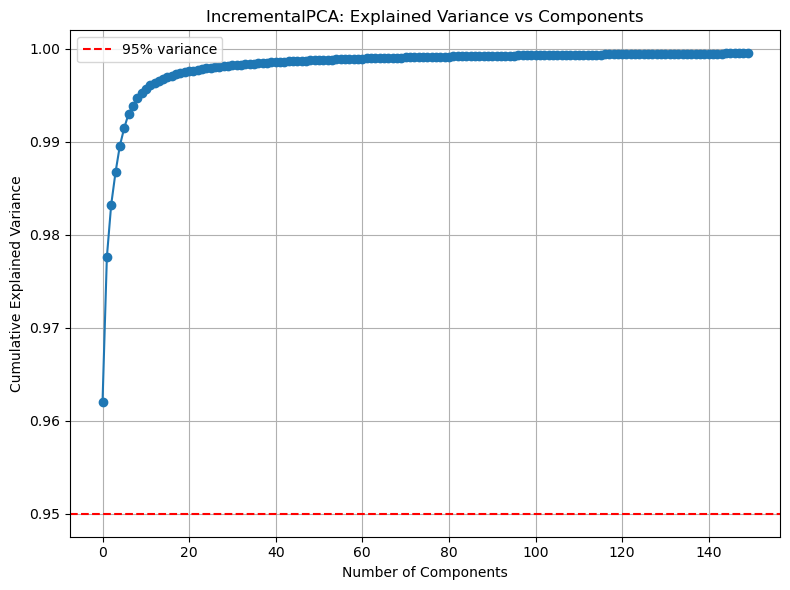

[INFO] Этап transform:


Трансформация: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 331/331 [00:08<00:00, 38.97it/s]


[INFO] Итоговая форма: (330975, 150)
[SAVED] Сохранено: content/films/user_vectors_reduced_ipca_batched.npz


In [23]:
user_vectors_reduced, evr, cumulative = reduce_dimensionality_sparse_incremental(
    user_vectors,
    save_path="content/films/user_vectors_reduced_ipca_batched.npz",
    n_components=150,
    batch_size=1000  
)

In [33]:
def reduce_dimensionality_incremental_movies(X_dict, save_path, n_components=150, batch_size=2000, plot_variance=True):


    print(f"[INFO] Преобразуем словарь в numpy array...")
    keys = list(X_dict.keys())
    X = np.array([X_dict[k] for k in keys])  # <- это сработает, т.к. массивы одинаковой длины

    ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
    print(f"[INFO] Начало обучения IncrementalPCA (n_components={n_components}, batch_size={batch_size})...")
    
    for i in tqdm(range(0, X.shape[0], batch_size), desc="Обучение IncrementalPCA"):
        batch = X[i:i+batch_size]
        ipca.partial_fit(batch)

    cumulative_variance = np.cumsum(ipca.explained_variance_ratio_)
    n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
    print(f"[INFO] Чтобы объяснить ≥95% дисперсии, нужно {n_components_95} компонент.")

    if plot_variance:
        plt.figure(figsize=(10,5))
        plt.plot(cumulative_variance, marker='o')
        plt.axhline(0.95, color='red', linestyle='--')
        plt.title("Cumulative Explained Variance")
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Variance")
        plt.grid()
        plt.show()

    X_reduced = ipca.transform(X)
    np.savez_compressed(save_path, X=X_reduced, keys=keys)
    print(f"[INFO] Сохранено: {save_path}")

    # Собираем словарь обратно
    reduced_dict = {k: X_reduced[i] for i, k in enumerate(keys)}
    return reduced_dict, ipca.explained_variance_ratio_, cumulative_variance


[INFO] Преобразуем словарь в numpy array...
[INFO] Начало обучения IncrementalPCA (n_components=150, batch_size=1000)...


Обучение IncrementalPCA: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:19<00:00,  4.35it/s]


[INFO] Чтобы объяснить ≥95% дисперсии, нужно 1 компонент.


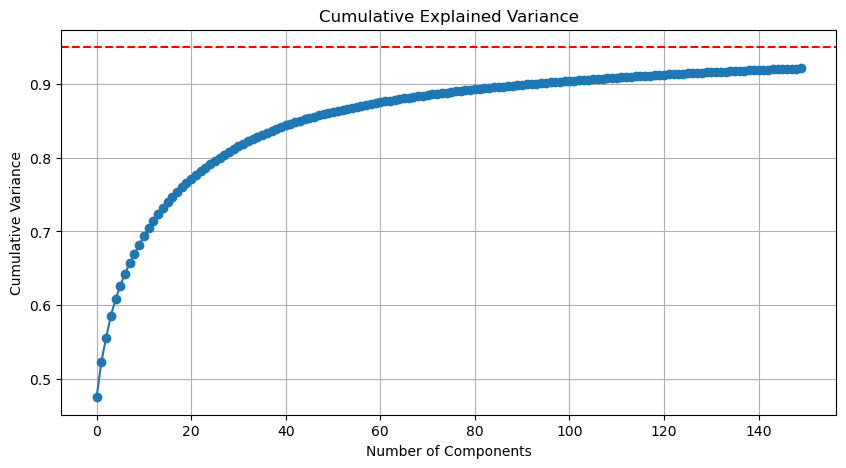

[INFO] Сохранено: content/films/movie_vectors_reduced_ipca_batched.npz


In [34]:
movie_vectors_reduced, evr, cumulative = reduce_dimensionality_incremental_movies(
    movie_vectors,
    save_path="content/films/movie_vectors_reduced_ipca_batched.npz",
    n_components=150,
    batch_size=1000
)

In [ ]:
# Загружаем
loaded_data = np.load('content/films/movie_vectors_reduced_ipca_batched.npz')
movie_vectors_reduced= loaded_data['X']
print(f"[ℹ️] Загружен массив формы: {movie_vectors_reduced.shape}")

In [ ]:
# Загружаем
loaded_data = np.load('content/films/user_vectors_reduced_ipca_batched.npz')
user_vectors_reduced= loaded_data['X']
print(f"[ℹ️] Загружен массив формы: {user_vectors_reduced.shape}")

In [34]:
# Кодируем пользователей и фильмы в индексы
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

ratings['user_idx'] = user_encoder.fit_transform(ratings['userId'])
ratings['item_idx'] = item_encoder.fit_transform(ratings['movieId'])

In [36]:
# 1. Подготовка данных: создаем матрицу взаимодействий user-item (пользователь - фильм)
ratings_matrix = csr_matrix((
    ratings['rating'],
    (ratings['user_idx'], ratings['item_idx'])
))

In [37]:
als_model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=10)
als_model.fit(ratings_matrix)

  0%|          | 0/10 [00:00<?, ?it/s]

In [46]:
internal_user_id = 1

# Рекомендуем фильмы для конкретного пользователя
recommended = als_model.recommend(internal_user_id, user_interaction, N=10)

# Извлекаем только movieId из результатов
recommended_movie_ids = recommended[0]

# Создаем DataFrame из рекомендованных фильмов
recommended_df = pd.DataFrame(recommended_movie_ids, columns=['movieId'])

# Подтягиваем жанры для рекомендованных фильмов
recommended_df = recommended_df.merge(movies[['movieId', 'title', 'genres']], on='movieId', how='left')

# Выводим результат
recommended_df

,movieId,title,genres
0,312,Stuart Saves His Family (1995),Comedy
1,324,"Sum of Us, The (1994)",Comedy|Drama
2,405,Highlander III: The Sorcerer (a.k.a. Highlander: The Final Dimension) (1994),Action|Fantasy
3,31,Dangerous Minds (1995),Drama
4,61,Eye for an Eye (1996),Drama|Thriller
5,503,"New Age, The (1994)",Drama
6,469,"House of the Spirits, The (1993)",Drama|Romance
7,430,Calendar Girl (1993),Comedy|Drama
8,721,Halfmoon (Paul Bowles - Halbmond) (1995),Drama
9,363,"Wonderful, Horrible Life of Leni Riefenstahl, The (Macht der Bilder: Leni Riefenstahl, Die) (1993)",Documentary
